In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numba 
from sklearn.model_selection import train_test_split
import random

C:\Users\michelle\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 讀取資料

In [2]:
x= pd.read_csv('pm25_hour_forecast_interpolate.csv', header = None, sep = ' ')
y= pd.read_csv('pm25_hour_observe_interpolate.csv', header = None, sep = ' ')
print("x.shape = ",x.shape)
print("y.shape = ",y.shape)

x.shape =  (365, 4752)
y.shape =  (368, 4752)


In [3]:
x = np.array(x)
y = np.array(y)
y = y[3:,:]
y.shape

(365, 4752)

## regression model

In [4]:
class regression:
    def __init__(self,x,y, sd, lambda_alpha,lambda_b, training_epoch , lr = 0.001, model_select = 1 ):
        #輸入值的初始化
        n,p = x.shape
        station = p/72
        self.sd = sd 
        self.lr = lr
        self.training_epoch = training_epoch
        self.x = x #data
        self.y = y #data
        self.lambda_alpha = lambda_alpha
        self.lambda_b = lambda_b
        self.model_select = model_select
        #變數的假設
        X = tf.placeholder(tf.float32, shape = (None, p), name = 'phy')
        Y = tf.placeholder(tf.float32, shape = (None, p), name = 'pre')
        self.X = X
        self.Y = Y

        #if model ==1
        #model_1

        #變數的初始化

        if self.model_select == 1:
            alpha_1 = tf.Variable(sd * tf.random_uniform(shape = [1, p], dtype=tf.float32), name="alpha_1", trainable=True)
            b_1 =  tf.Variable(1., name="b_1", trainable = True)
            model_1 = tf.add(tf.multiply(b_1, self.X), alpha_1)
            self.alpha = alpha_1
            self.b = b_1
            self.model = model_1
        if self.model_select == 2:
            alpha_2 = tf.Variable(sd * tf.random_uniform(shape = [1, p], dtype=tf.float32), name = "alpha_2", trainable = True)
            b_2 = tf.Variable(tf.zeros([1, station], tf.float32), name = "b_2", trainable = True)
            model_2 = tf.add( tf.multiply( tf.tile(b_2, multiples = [1,72]), self.X), alpha_2)
            self.alpha = alpha_2
            self.b = b_2
            self.model = model_2
        if self.model_select == 3:
            alpha_3 = tf.Variable( sd * tf.random_uniform(shape = [1, p], dtype=tf.float32), name = "alpha_3", trainable = True)
            b_3 = tf.Variable( tf.zeros([1, p], tf.float32), name = "b_3", trainable = True)
            model_3 = tf.add( tf.multiply(b_3, self.X), alpha_3)
            self.alpha = alpha_3
            self.b = b_3
            self.model = model_3
        if self.model_select == 4:
            alpha_4 = tf.Variable( sd * tf.random_uniform(shape = [1, p], dtype=tf.float32), name = "alpha_4", trainable = True)
            b_4 = tf.Variable( tf.zeros([p, p], tf.float32), name = "b_4", trainable = True)
            model_4 = tf.add( tf.matmul(b_4, tf.transpose(self.X)), alpha_4) #矩陣相乘
            self.alpha = alpha_4
            self.b = b_4
            self.model = tf.transpose(model_4)
        #model的初始化
   
        self.cost = tf.reduce_mean(tf.square(tf.subtract(self.Y, self.model))) + \
        self.lambda_alpha * (tf.reduce_sum(tf.square(self.alpha))) + \
        self.lambda_b * (tf.reduce_sum(tf.square(self.b)))
        self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.cost)
        
        #切割data(train test)
        self.x_train = self.x[:-31,:]
        self.x_test  = self.x[-31:,:]
        self.y_train = self.y[:-31,:]
        self.y_test  = self.y[-31:,:]
        
        self.x_, self.x_vali, self.y_, self.y_vali = train_test_split(self.x_train, self.y_train,
                                                                test_size = 0.3, random_state = 42)
        

    def train(self,select_hy):
        if select_hy==1: #驗證超參數
            xs = self.x_vali 
            ys = self.y_vali             
        if select_hy==0: #訓練模型
            xs = self.x_ 
            ys = self.y_ 
            
        sess = tf.Session()
        init = tf.global_variables_initializer()
        sess.run(init)

        prev_err = 0
        costs_train = np.zeros((1,self.training_epoch))
        costs_test = np.zeros((1,self.training_epoch))

        for epoch in range(self.training_epoch):
            err, _ = sess.run([self.cost, self.train_op], feed_dict = {self.X: xs, self.Y: ys})
            if  select_hy ==0: #利用test確認有無overfitting
                cost_test = sess.run(self.cost, feed_dict ={self.X: self.x_vali, self.Y: self.y_vali})
                costs_test[0][epoch] = cost_test
            costs_train[0][epoch] = err
           
            '''''
            if epoch % 100 == 0:
                print(epoch, err)
               '''''
            if abs(prev_err - err) < 1e-10:
                break
            prev_err = err
         
        alpha_val= sess.run(self.alpha)
        self.alpha_val  = alpha_val
        b_val = sess.run(self.b)  
        self.b_val  = b_val
    
        
        return  costs_train[costs_train!= 0], costs_test[costs_test!=0]

    def test(self, test_or_not = None):
        if self.model_select==1 or self.model_select==3 :
            y_hat = np.add(np.multiply(self.b_val, self.x_test), self.alpha_val)

        if self.model_select==2:
            y_hat = np.add( np.multiply( np.tile(self.b_val, reps = (1,72) ), self.x_test), self.alpha_val)
        
        if self.model_select==4:
            y_hat = np.add(np.dot(self.b_val, self.x_test.T), self.alpha_val).T
            
        if test_or_not:
            loss = np.mean(abs(self.y_test-y_hat))
        else:
            loss = np.mean( (self.y_test-y_hat)**2 ) + \
                    self.lambda_alpha * ( np.sum(self.alpha_val**2) ) + \
                    self.lambda_b * ( np.sum(self.b_val**2) )            
        
        return loss
    
    def original_loss(self):
        loss_original = np.mean(abs(self.x_test - self.y_test)) 
        
        return loss_original

## 最佳化
### 利用MSE找出最佳的初始值

In [19]:
def best_model_for_alpha_b(c_alpha,c_b,model):#逞罰項係數 dropout rate
    n_alpha = len(c_alpha)
    n_b = len(c_b)
    cost_vali = np.zeros((n_alpha * n_b,3)) 
    
    num = 0
    aa,bb = np.meshgrid(c_alpha,c_b,indexing='ij')
    for i in zip(aa.flat, bb.flat): 
        cost_vali[num][:2] = np.array(i)
        re = regression(x,y , sd = 0.5,lambda_alpha = np.array(i)[0], lambda_b = np.array(i)[1],\
                        training_epoch = 10000, lr = 0.01, model_select = model)
        err = re.train(select_hy = 1)[0][-1]
        cost_vali[num][2] = err
        #print('iter',num)
        num = num+1
    
    cost_vali = cost_vali[cost_vali[:,2].argsort()]
    
    print(cost_vali)
    print(cost_vali[:4,:])
    
    return cost_vali[:4,:]

## model 1

### 第一次逞罰項最佳化

c_alpha = $10^{-5}$ ~ $10^{5} $ ;
c_b = 0

In [20]:
c_alpha = (10. ** (np.arange(11)-5)).astype(np.float32)
c_b = np.array([0])
best_model_for_alpha_b(c_alpha,c_b,1)

[[9.99999975e-06 0.00000000e+00 2.00243835e+02]
 [9.99999975e-05 0.00000000e+00 3.35076233e+02]
 [1.00000005e-03 0.00000000e+00 5.30442078e+02]
 [9.99999978e-03 0.00000000e+00 5.81172913e+02]
 [1.00000001e-01 0.00000000e+00 5.87095215e+02]
 [1.00000000e+00 0.00000000e+00 5.87687927e+02]
 [1.00000000e+01 0.00000000e+00 5.87748718e+02]
 [1.00000000e+02 0.00000000e+00 5.87754333e+02]
 [1.00000000e+05 0.00000000e+00 5.87755005e+02]
 [1.00000000e+04 0.00000000e+00 5.87755371e+02]
 [1.00000000e+03 0.00000000e+00 5.87755493e+02]]
[[9.99999975e-06 0.00000000e+00 2.00243835e+02]
 [9.99999975e-05 0.00000000e+00 3.35076233e+02]
 [1.00000005e-03 0.00000000e+00 5.30442078e+02]
 [9.99999978e-03 0.00000000e+00 5.81172913e+02]]


array([[9.99999975e-06, 0.00000000e+00, 2.00243835e+02],
       [9.99999975e-05, 0.00000000e+00, 3.35076233e+02],
       [1.00000005e-03, 0.00000000e+00, 5.30442078e+02],
       [9.99999978e-03, 0.00000000e+00, 5.81172913e+02]])

### 第二次逞罰項最佳化

In [23]:
c_alpha = (np.linspace(1e-6, 1e-5,10)).astype(np.float32)
c_b = np.array([0])
best_2 = best_model_for_alpha_b(c_alpha,c_b,1)
print(best_2)

[[9.99999997e-07 0.00000000e+00 1.78091629e+02]
 [1.99999999e-06 0.00000000e+00 1.80678375e+02]
 [3.00000011e-06 0.00000000e+00 1.83236481e+02]
 [3.99999999e-06 0.00000000e+00 1.85759949e+02]
 [4.99999987e-06 0.00000000e+00 1.88252899e+02]
 [6.00000021e-06 0.00000000e+00 1.90709518e+02]
 [7.00000010e-06 0.00000000e+00 1.93136780e+02]
 [7.99999998e-06 0.00000000e+00 1.95535675e+02]
 [9.00000032e-06 0.00000000e+00 1.97901794e+02]
 [9.99999975e-06 0.00000000e+00 2.00242233e+02]]
[[9.99999997e-07 0.00000000e+00 1.78091629e+02]
 [1.99999999e-06 0.00000000e+00 1.80678375e+02]
 [3.00000011e-06 0.00000000e+00 1.83236481e+02]
 [3.99999999e-06 0.00000000e+00 1.85759949e+02]]
[[9.99999997e-07 0.00000000e+00 1.78091629e+02]
 [1.99999999e-06 0.00000000e+00 1.80678375e+02]
 [3.00000011e-06 0.00000000e+00 1.83236481e+02]
 [3.99999999e-06 0.00000000e+00 1.85759949e+02]]


In [24]:
min_alpha = best_2[0,0]
min_b = best_2[0,1]

## 超參數代入training的值計算

In [51]:
re_1=regression(x,y , sd = 0.5,lambda_alpha = min_alpha, lambda_b = min_b,\
                        training_epoch = 50000, lr = 0.01, model_select = 1)
train = re_1.train(select_hy = 0)
#print('train_cost = ',train[0])
#print('test_cost = ',test[0])

## 比較train V.S test之間是否overfitting

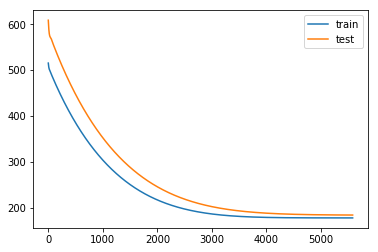

In [52]:
plt.plot(train[0],label = 'train')
plt.plot(train[1],label = 'test')
plt.legend()

## 比較與物理模型之間的差異(全部樣本)

#### 物理模型

In [53]:
re_1.original_loss()

21.087475797785913

#### model_1

In [54]:
re_1.test(test_or_not=1)

11.56940345576666

## model_2


In [57]:
c_alpha = (10. ** (np.arange(11)-5)).astype(np.float32)
c_b = (10. ** (np.arange(11)-5)).astype(np.float32)
best_model_for_alpha_b(c_alpha,c_b,2)

[[9.99999975e-06 9.99999975e-06 1.97097260e+02]
 [9.99999975e-06 9.99999975e-05 1.97098328e+02]
 [9.99999975e-06 1.00000005e-03 1.97102356e+02]
 [9.99999975e-06 9.99999978e-03 1.97132584e+02]
 [9.99999975e-06 1.00000001e-01 1.97443741e+02]
 [9.99999975e-06 1.00000000e+00 1.99644318e+02]
 [9.99999975e-06 1.00000000e+01 2.04891891e+02]
 [9.99999975e-06 1.00000000e+02 2.07392273e+02]
 [9.99999975e-06 1.00000000e+03 2.07703491e+02]
 [9.99999975e-06 1.00000000e+04 2.07766296e+02]
 [9.99999975e-06 1.00000000e+05 2.08422546e+02]
 [9.99999975e-05 9.99999975e-05 3.20663940e+02]
 [9.99999975e-05 9.99999975e-06 3.20664612e+02]
 [9.99999975e-05 1.00000005e-03 3.20681580e+02]
 [9.99999975e-05 9.99999978e-03 3.20845947e+02]
 [9.99999975e-05 1.00000001e-01 3.22349762e+02]
 [9.99999975e-05 1.00000000e+00 3.33344421e+02]
 [9.99999975e-05 1.00000000e+01 3.61948151e+02]
 [9.99999975e-05 1.00000000e+02 3.76482758e+02]
 [9.99999975e-05 1.00000000e+04 3.78864471e+02]
 [9.99999975e-05 1.00000000e+05 3.793696

array([[9.99999975e-06, 9.99999975e-06, 1.97097260e+02],
       [9.99999975e-06, 9.99999975e-05, 1.97098328e+02],
       [9.99999975e-06, 1.00000005e-03, 1.97102356e+02],
       [9.99999975e-06, 9.99999978e-03, 1.97132584e+02]])

### 第二次最佳化

In [58]:
c_alpha = np.array([1e-5])
c_b = (np.linspace(1e-6, 1e-3,10)).astype(np.float32)
best_2 = best_model_for_alpha_b(c_alpha,c_b,2)
print(best_2)

[[1.00000000e-05 2.22999995e-04 1.97097641e+02]
 [1.00000000e-05 9.99999997e-07 1.97099167e+02]
 [1.00000000e-05 5.55999984e-04 1.97099731e+02]
 [1.00000000e-05 7.77999987e-04 1.97099899e+02]
 [1.00000000e-05 6.67000015e-04 1.97100235e+02]
 [1.00000000e-05 1.00000005e-03 1.97100250e+02]
 [1.00000000e-05 3.34000011e-04 1.97100815e+02]
 [1.00000000e-05 4.45000012e-04 1.97102051e+02]
 [1.00000000e-05 8.89000017e-04 1.97102737e+02]
 [1.00000000e-05 1.12000002e-04 1.97102890e+02]]
[[1.00000000e-05 2.22999995e-04 1.97097641e+02]
 [1.00000000e-05 9.99999997e-07 1.97099167e+02]
 [1.00000000e-05 5.55999984e-04 1.97099731e+02]
 [1.00000000e-05 7.77999987e-04 1.97099899e+02]]
[[1.00000000e-05 2.22999995e-04 1.97097641e+02]
 [1.00000000e-05 9.99999997e-07 1.97099167e+02]
 [1.00000000e-05 5.55999984e-04 1.97099731e+02]
 [1.00000000e-05 7.77999987e-04 1.97099899e+02]]


In [59]:
min_alpha = best_2[0,0]
min_b = best_2[0,1]

## 比較train V.S test之間是否overfitting

In [60]:
re_2=regression(x,y , sd = 0.5,lambda_alpha = min_alpha, lambda_b = min_b,\
                        training_epoch = 50000, lr = 0.01, model_select = 2)
train = re_2.train(select_hy = 0)
#print('train_cost = ',train[0])
#print('test_cost = ',test[0])

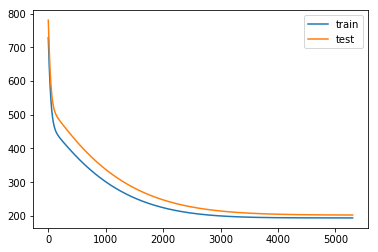

In [61]:
plt.plot(train[0],label = 'train')
plt.plot(train[1],label = 'test')
plt.legend()

## 比較與物理模型之間的差異(全部樣本)

In [62]:
re_2.original_loss()

21.087475797785913

In [63]:
re_2.test(test_or_not = 1)

11.6124103984825

## model_3

### 第一次逞罰項最佳化

In [64]:
c_alpha = (10. ** (np.arange(11)-5)).astype(np.float32)
c_b = (10. ** (np.arange(11)-5)).astype(np.float32)
best_model_for_alpha_b(c_alpha,c_b,3)

[[9.99999975e-06 9.99999975e-06 1.94002563e+02]
 [9.99999975e-06 9.99999975e-05 1.94048126e+02]
 [9.99999975e-06 1.00000005e-03 1.94483734e+02]
 [9.99999975e-06 9.99999978e-03 1.97206085e+02]
 [9.99999975e-06 1.00000001e-01 2.03470871e+02]
 [9.99999975e-06 1.00000000e+00 2.07020660e+02]
 [9.99999975e-06 1.00000000e+01 2.07877029e+02]
 [9.99999975e-06 1.00000000e+02 2.08131485e+02]
 [9.99999975e-06 1.00000000e+04 2.11024597e+02]
 [9.99999975e-06 1.00000000e+03 2.34595825e+02]
 [9.99999975e-06 1.00000000e+05 2.40361389e+02]
 [9.99999975e-05 9.99999975e-06 3.10526672e+02]
 [9.99999975e-05 9.99999975e-05 3.10752167e+02]
 [9.99999975e-05 1.00000005e-03 3.12789978e+02]
 [9.99999975e-05 9.99999978e-03 3.25757294e+02]
 [9.99999975e-05 1.00000001e-01 3.56947021e+02]
 [9.99999975e-05 1.00000000e+00 3.75238220e+02]
 [9.99999975e-05 1.00000000e+01 3.78567047e+02]
 [9.99999975e-05 1.00000000e+03 3.79414948e+02]
 [9.99999975e-05 1.00000000e+02 3.79815277e+02]
 [9.99999975e-05 1.00000000e+04 3.809616

array([[9.99999975e-06, 9.99999975e-06, 1.94002563e+02],
       [9.99999975e-06, 9.99999975e-05, 1.94048126e+02],
       [9.99999975e-06, 1.00000005e-03, 1.94483734e+02],
       [9.99999975e-06, 9.99999978e-03, 1.97206085e+02]])

### 第二次最佳化

In [65]:
c_alpha = np.array([1e-5])
c_b = (np.linspace(1e-6, 1e-3,10)).astype(np.float32)
best_2 = best_model_for_alpha_b(c_alpha,c_b,3)
print(best_2)

[[1.00000000e-05 9.99999997e-07 1.93994110e+02]
 [1.00000000e-05 1.12000002e-04 1.94054703e+02]
 [1.00000000e-05 2.22999995e-04 1.94111908e+02]
 [1.00000000e-05 3.34000011e-04 1.94165466e+02]
 [1.00000000e-05 4.45000012e-04 1.94222214e+02]
 [1.00000000e-05 5.55999984e-04 1.94277924e+02]
 [1.00000000e-05 6.67000015e-04 1.94329636e+02]
 [1.00000000e-05 7.77999987e-04 1.94387802e+02]
 [1.00000000e-05 8.89000017e-04 1.94434326e+02]
 [1.00000000e-05 1.00000005e-03 1.94483047e+02]]
[[1.00000000e-05 9.99999997e-07 1.93994110e+02]
 [1.00000000e-05 1.12000002e-04 1.94054703e+02]
 [1.00000000e-05 2.22999995e-04 1.94111908e+02]
 [1.00000000e-05 3.34000011e-04 1.94165466e+02]]
[[1.00000000e-05 9.99999997e-07 1.93994110e+02]
 [1.00000000e-05 1.12000002e-04 1.94054703e+02]
 [1.00000000e-05 2.22999995e-04 1.94111908e+02]
 [1.00000000e-05 3.34000011e-04 1.94165466e+02]]


In [66]:
min_alpha = best_2[0,0]
min_b = best_2[0,1]

## 比較train V.S test之間是否overfitting

In [67]:
re_3 = regression(x, y, sd = 0.5,lambda_alpha = min_alpha, lambda_b = min_b,\
                        training_epoch = 50000, lr = 0.01, model_select = 3)
train = re_3.train(select_hy = 0)
#print('train_cost = ',train[0])
#print('test_cost = ',test[0])

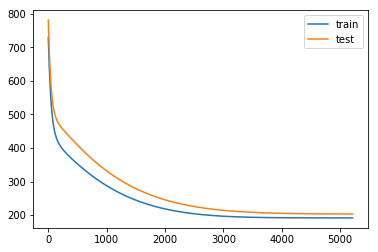

In [68]:
plt.plot(train[0],label = 'train')
plt.plot(train[1],label = 'test')
plt.legend()

## 比較與物理模型之間的差異(全部樣本)

In [69]:
re_3.original_loss()

21.087475797785913

In [70]:
re_3.test(test_or_not = 1)

11.67921493790528